In [10]:
# import required libraries
import numpy as np
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate, Dropout
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.applications import VGG16, ResNet50, InceptionV3
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
from tensorflow.keras import Input 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Cell.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  #print('Done')

extracted_file_path = "/content/drive/MyDrive/Cell" 

In [12]:
# Defining Image Data Gen
WIDTH = 130
HEIGHT = 130 
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rescale=1/225,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              validation_split=0.2)

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/cell_images/cell_images',
  validation_split=0.2,
  color_mode = "grayscale",
  subset="validation",
  seed=69,
  image_size=(WIDTH, HEIGHT),
  batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [19]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  '/content/cell_images/cell_images',
  validation_split=0.2,
  color_mode = "grayscale",
  subset="training",
  seed=69,
  image_size=(WIDTH, HEIGHT),
  batch_size=BATCH_SIZE)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [20]:
# find how many batches are in val_data
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 2)
val_data = val_data.skip(val_batches // 2)

In [21]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))

Number of validation batches: 87
Number of test batches: 86


In [22]:
class_names = train_data.class_names
print(class_names)

['Parasitized', 'Uninfected']


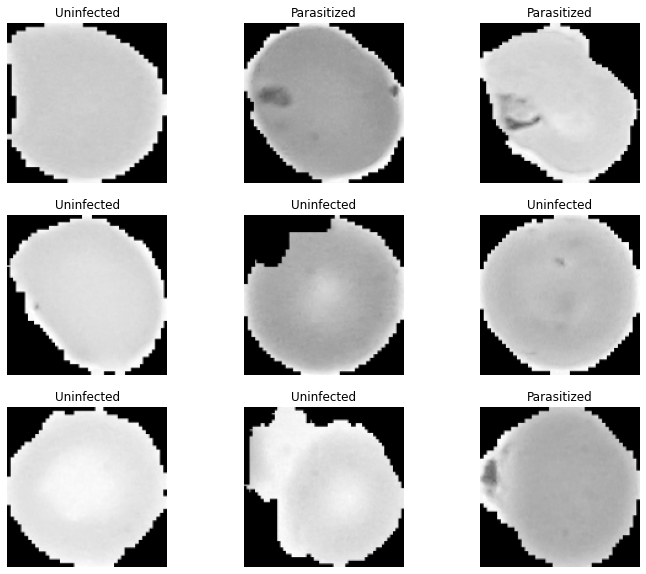

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
# performance boosting code --> prefetching 

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [25]:
# applying data augmentation
data_augmentation = tf.keras.Sequential(
[
  RandomFlip('horizontal'),
  RandomRotation(0.25),
], "Augmentation_Layers")

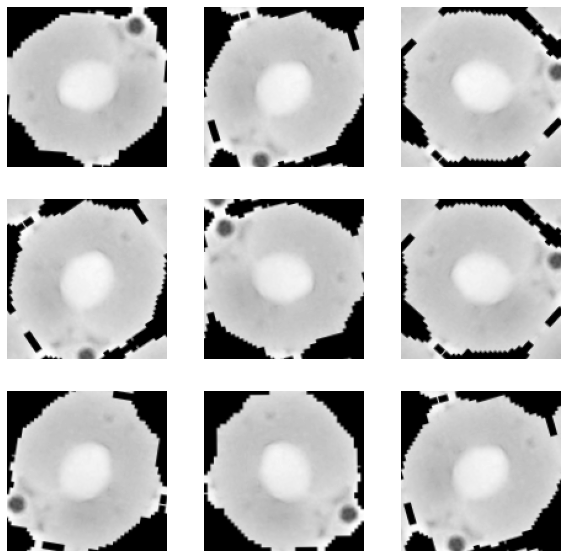

In [26]:
#seeing the effects of our data augmentation 

for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255, cmap="gray")
    plt.axis('off')

In [27]:
# scale the inputs to between -1 to 1 
rescale = Rescaling(scale=1./127.5, offset=-1)

inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, 1))
x = data_augmentation(inputs)
x = rescale(x)

x = Conv2D(128, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(128, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(64, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = BatchNormalization(axis=1)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 130, 130, 1)]     0         
                                                                 
 Augmentation_Layers (Sequen  (None, 130, 130, 1)      0         
 tial)                                                           
                                                                 
 rescaling (Rescaling)       (None, 130, 130, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 130, 130, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 65, 65, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 65, 65, 128)      260   

In [29]:
lr = 0.001
model.compile(optimizer=Adam(learning_rate=lr),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
epochs = 10
early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
history = model.fit(train_data,
                    epochs=epochs,
                    validation_data=val_data, callbacks=[early_stop])

Epoch 1/10


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


689/689 [==============================] - 121s 150ms/step - loss: 0.4038 - accuracy: 0.7996 - val_loss: 0.1582 - val_accuracy: 0.9500
Epoch 2/10
689/689 [==============================] - 100s 145ms/step - loss: 0.1697 - accuracy: 0.9421 - val_loss: 0.1411 - val_accuracy: 0.9525
Epoch 3/10
689/689 [==============================] - 100s 145ms/step - loss: 0.1564 - accuracy: 0.9471 - val_loss: 0.1267 - val_accuracy: 0.9583
Epoch 4/10
689/689 [==============================] - 100s 145ms/step - loss: 0.1473 - accuracy: 0.9506 - val_loss: 0.1278 - val_accuracy: 0.9558
Epoch 5/10
689/689 [==============================] - 101s 147ms/step - loss: 0.1430 - accuracy: 0.9508 - val_loss: 0.1484 - val_accuracy: 0.9493
Epoch 6/10
689/689 [==============================] - 100s 145ms/step - loss: 0.1382 - accuracy: 0.9522 - val_loss: 0.1234 - val_accuracy: 0.9590
Epoch 7/10
689/689 [==============================] - 101s 146ms/step - loss: 0.1330 - accuracy: 0.9542 - val_loss: 0.1158 - val_accura

In [31]:
model.evaluate(test_data)

86/86 [==============================] - 5s 47ms/step - loss: 0.1180 - accuracy: 0.9557


[0.11797253042459488, 0.9556686282157898]

In [32]:
val_loss=history.history['val_loss']
train_loss=history.history['loss']

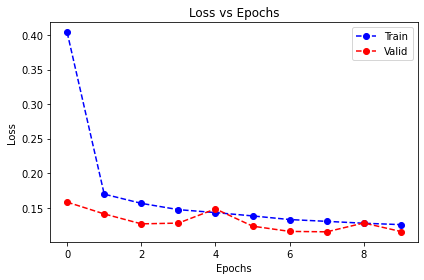

In [33]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss,'bo--')
plt.plot(val_loss,'ro--')
plt.title('Loss vs Epochs')
plt.legend(['Train','Valid'])
plt.tight_layout()
plt.show()

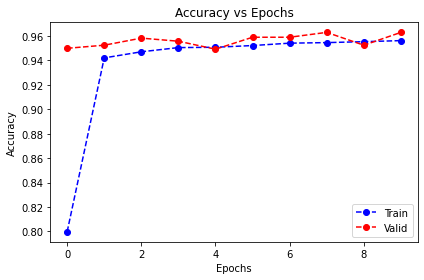

In [35]:
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.epoch, history.history['accuracy'],'bo--')
plt.plot(history.epoch, history.history['val_accuracy'],'ro--'tf.keras.utils.plot_model(model,show_shapes=True,rankdir='LR'))
# plt.plot(train_loss,'bo--')
# plt.plot(val_loss,'ro--')
plt.title('Accuracy vs Epochs')
plt.legend(['Train','Valid'])
plt.tight_layout()
plt.show()

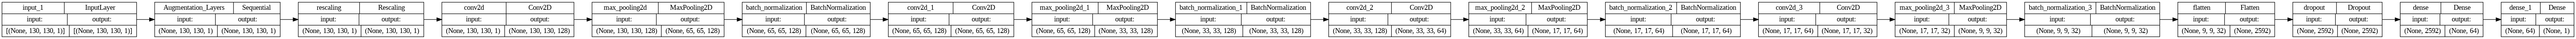

In [36]:
tf.keras.utils.plot_model(model,show_shapes=True,rankdir='LR')

In [38]:
 from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report  
results = confusion_matrix 
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',history.history['accuracy'] )
print ('Report : ')
print (history.history['val_accuracy']) 

Confusion Matrix :
<function confusion_matrix at 0x7eff8ab26280>
Accuracy Score : [0.799609899520874, 0.9421236515045166, 0.9471129775047302, 0.9505601525306702, 0.9508323073387146, 0.9522383809089661, 0.9541887640953064, 0.9546423554420471, 0.9554134607315063, 0.956275224685669]
Report : 
[0.9499818682670593, 0.9525189995765686, 0.9583182334899902, 0.955781102180481, 0.949256956577301, 0.9590431451797485, 0.9590431451797485, 0.9630300998687744, 0.9525189995765686, 0.9630300998687744]


In [46]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
# Make predictions on the test data
y_pred = model.predict(test_data)
y_pred = np.round(y_pred).flatten()

# Obtain the true labels for the test data
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true = y_true.flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)


86/86 [==============================] - 2s 25ms/step
[[675 706]
 [711 660]]
